In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [1]:
from urllib.request import urlopen
from urllib.request import Request
import json
import matplotlib.pyplot as plotter
from prettytable import PrettyTable

x = PrettyTable()
#x.field_names=["identifier","title","version","firstPublished","lastPublished","workflowstatus","id","name","url","severity","workarounds","cwe","cve","ciscoBugId","status","summary","totalcount","realtedResource"]
x.field_names=["Identifer","Severity","Title","ciscoBugId"]
request=urlopen("https://tools.cisco.com/security/center/publicationService.x?cves=&identifiers=&last_published_date=&limit=20&offset=0&publicationTypeIDs=1,3&resourceIDs=93036&securityImpactRatings=&sort=-last_published&title=")
cisco_data = request.read()
data = json.loads(cisco_data)
data = sorted(data, key=lambda k: k.get('severity', 0), reverse=False)
entries=len(data)
count=0
critical=0
high=0
medium=0
while count < entries:
#for identifier,title,version,firstPublished,lastPublished,workflowstatus,id,name,url,severity,workarounds,cwe,cve,ciscoBugId,status,summary,totalcount,realtedResource in data:
    x.add_row([data[count]['identifier'],data[count]['severity'],data[count]['title'],(data[count]['ciscoBugId']).replace(',','\n')])
    if data[count]['severity'] == 'Critical': critical+=1
    if data[count]['severity'] == 'High': high+=1
    if data[count]['severity'] == 'Medium': medium+=1
    count+=1
#print(x)
from IPython.core.display import display, HTML
display(HTML("<h1>Cisco Last 20 Vulnerabilities Feed</h1>"))
display(HTML(x.get_html_string()))

Identifer,Severity,Title,ciscoBugId
cisco-sa-20190828-iosxe-rest-auth-bypass,Critical,Cisco REST API Container for IOS XE Software Authentication Bypass Vulnerability,CSCvn93524CSCvo47376
cisco-sa-20200108-ios-csrf,High,Cisco IOS and Cisco IOS XE Software Web UI Cross-Site Request Forgery Vulnerability,CSCvq66030
cisco-sa-20190925-ftp,High,"Cisco IOS XE Software FTP Application Layer Gateway for NAT, NAT64, and ZBFW Denial of Service Vulnerability",CSCvn02419
cisco-sa-20190925-webui-cmd-injection,High,Cisco IOS XE Software Web UI Command Injection Vulnerabilities,CSCvo61821CSCvp78858CSCvp95724
cisco-sa-20190925-sip-dos,High,Cisco IOS and IOS XE Software Session Initiation Protocol Denial of Service Vulnerability,CSCvn00218
cisco-sa-20190925-sip-alg,High,Cisco IOS XE Software NAT Session Initiation Protocol Application Layer Gateway Denial of Service Vulnerability,CSCvn65912
cisco-sa-20190925-rawtcp-dos,High,Cisco IOS XE Software Raw Socket Transport Denial of Service Vulnerability,CSCvj91021
cisco-sa-20190925-iosxe-fsdos,High,Cisco IOS XE Software Filesystem Exhaustion Denial of Service Vulnerability,CSCvf80363
cisco-sa-20190925-utd,High,Cisco IOS XE Software Unified Threat Defense Denial of Service Vulnerability,CSCvn29244
cisco-sa-20190925-iosxe-digsig-bypass,High,Cisco IOS XE Software Digital Signature Verification Bypass Vulnerability,CSCvj87117CSCvk12460


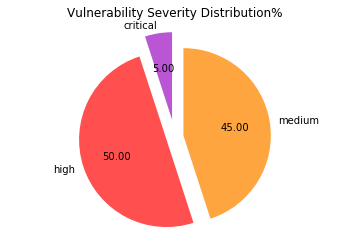

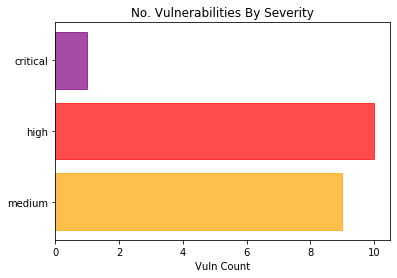

In [3]:
pieLabels=['critical','high','medium']
severitypie=[critical,high,medium]
#print("total %d" %(critical+high+medium))
#print("critical:%d high:%d medium:%d" %(critical, high, medium))
explodeTuple = (0.2, 0.1, 0.1)
figureObject, axesObject = plotter.subplots()
pie=axesObject.pie(severitypie, 
        explode=explodeTuple,
        labels=pieLabels,
        autopct='%1.2f',
        colors=['mediumorchid','#FF4F4F','#FFA53F'],
        startangle=90)
axesObject.axis('equal')
plotter.title('Vulnerability Severity Distribution%')
plotter.show()

figureObject, axesObject    = plotter.subplots()
barlist = axesObject.barh(('medium','high','critical'),
        (medium,high,critical),
        0.8,
        alpha = 0.7,
        color = 'blue',
        label = 'Vulns')
barlist[0].set_color('orange')
barlist[1].set_color('red')
barlist[2].set_color('purple')
axesObject.set_xlabel('Vuln Count')
plotter.title('No. Vulnerabilities By Severity')
plotter.show()

<function matplotlib.pyplot.show(*args, **kw)>

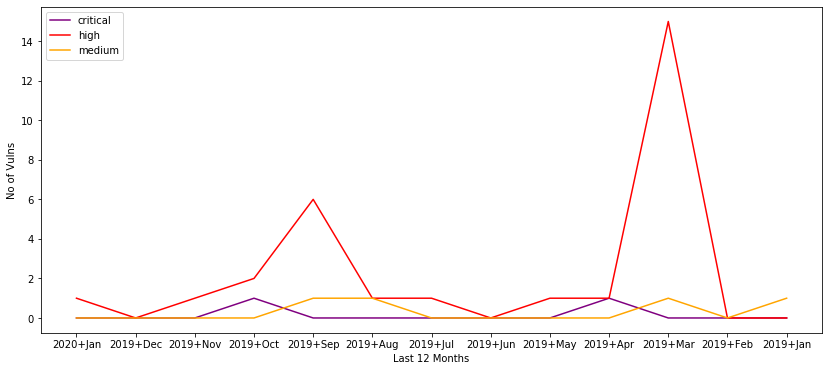

In [1]:
from urllib.request import urlopen
from urllib.request import Request
import json
import matplotlib.pyplot as plt
from datetime import date, timedelta
from IPython.display import HTML

display(HTML("<h2>Cisco Annual Vulnerabilities Tracker</h2>"))
dates=[]

today = date.today()
date_today = today.strftime("%Y+%b")
day_today=(int)(today.strftime("%d"))
dates.append(date_today)
for i in range(12):
    d5= today - timedelta(days=(31*i)+day_today)
    dates.append(d5.strftime("%Y+%b"))

critical_l=[]
high_l=[]
medium_l=[]
month=0
for date in dates:
    request=urlopen("https://tools.cisco.com/security/center/publicationService.x?cves=&identifiers=&last_published_date="+date+"&limit=20&offset=0&publicationTypeIDs=1,3&resourceIDs=93036&securityImpactRatings=&sort=-last_published&title=")
    cisco_data = request.read()
    data = json.loads(cisco_data)
    data = sorted(data, key=lambda k: k.get('severity', 0), reverse=False)
    entries=len(data)
    count=0
    critical=0
    high=0
    medium=0
    while count < entries:
        if data[count]['severity'] == 'Critical': critical+=1
        if data[count]['severity'] == 'High': high+=1
        if data[count]['severity'] == 'Medium': medium=+1
        count+=1
    critical_l.append(critical)
    high_l.append(high)
    medium_l.append(medium)

fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(111)
plt.plot(dates,critical_l, color="purple",label='critical')
plt.plot(dates,high_l, color="red",label='high')
plt.plot(dates,medium_l, color="orange",label='medium')
plt.xlabel('Last 12 Months')
plt.ylabel('No of Vulns')
plt.legend(loc=2)
plt.show

